Reza Soleimani 260984835

**End-to-end Machine Learning project - Causal Inference**

*Data source: https://www.kaggle.com/phileinsophos/predict-loan-amount-data?select=train.csv*


# 1. Framing the Problem

The selected dataset consists of ~30,000 loan application data and the issued loan amount. For each loan application, 24 variables are measured. These variables depict the information of each loan applicant. The objective is to predict sanctioned loan amount values for each application using regression models. From loan issuer perspective, this analysis can help to have an initial understanding of the expected loan that each applicant by specific information can get. 
Here, the core objective is to see the causal effect of having co-applicant on the amount of loan issued.

The hypothesis is that having co-applicant has causal effect on the amount of issued loan and would increase it. We will see if this assumption is correct

# Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

# Import the Data

In [2]:
import pandas as pd
loan_df = pd.read_csv ("Sanctioned Loan Amount Prediction Dataset.csv")
loan_df.dropna(subset=["Loan Sanction Amount (USD)"], inplace=True)  # drop rows with null values in label column
loan_df.reset_index(drop=True, inplace=True)   # reset the dataframe index 

# 2. Data exploration

In [3]:
loan_df.head()

,Customer ID,Name,Gender,Age,Income (USD),Income Stability,Profession,Type of Employment,Location,Loan Amount Request (USD),...,Credit Score,No. of Defaults,Has Active Credit Card,Property ID,Property Age,Property Type,Property Location,Co-Applicant,Property Price,Loan Sanction Amount (USD)
0,C-36995,Frederica Shealy,F,56,1933.05,Low,Working,Sales staff,Semi-Urban,72809.58,...,809.44,0,NaN,746,1933.05,4,Rural,1,119933.46,54607.18
1,C-33999,America Calderone,M,32,4952.91,Low,Working,NaN,Semi-Urban,46837.47,...,780.40,0,Unpossessed,608,4952.91,2,Rural,1,54791.00,37469.98
2,C-3770,Rosetta Verne,F,65,988.19,High,Pensioner,NaN,Semi-Urban,45593.04,...,833.15,0,Unpossessed,546,988.19,2,Urban,0,72440.58,36474.43
3,C-26480,Zoe Chitty,F,65,NaN,High,Pensioner,NaN,Rural,80057.92,...,832.70,1,Unpossessed,890,NaN,2,Semi-Urban,1,121441.51,56040.54
4,C-23459,Afton Venema,F,31,2614.77,Low,Working,High skill tech staff,Semi-Urban,113858.89,...,745.55,1,Active,715,2614.77,4,Semi-Urban,1,208567.91,74008.28


In [4]:
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29660 entries, 0 to 29659
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Customer ID                  29660 non-null  object 
 1   Name                         29660 non-null  object 
 2   Gender                       29608 non-null  object 
 3   Age                          29660 non-null  int64  
 4   Income (USD)                 25167 non-null  float64
 5   Income Stability             28002 non-null  object 
 6   Profession                   29660 non-null  object 
 7   Type of Employment           22472 non-null  object 
 8   Location                     29660 non-null  object 
 9   Loan Amount Request (USD)    29660 non-null  float64
 10  Current Loan Expenses (USD)  29493 non-null  float64
 11  Expense Type 1               29660 non-null  object 
 12  Expense Type 2               29660 non-null  object 
 13  Dependents      

In [5]:
loan_df["Customer ID"].value_counts()

C-22970    1
C-30539    1
C-29881    1
C-21800    1
C-27708    1
          ..
C-1474     1
C-5147     1
C-18844    1
C-18506    1
C-32292    1
Name: Customer ID, Length: 29660, dtype: int64

In [6]:
loan_df["Name"].value_counts()

Vaughn Lawry        1
Jani Bruce          1
Winford Decola      1
Enola Dodson        1
Joaquin Pavlik      1
                   ..
Margareta Tharpe    1
Krystin Huggett     1
Tandra Linen        1
Kena Para           1
Jeremiah Prigge     1
Name: Name, Length: 29660, dtype: int64

In [7]:
loan_df["Gender"].value_counts()

M    14890
F    14718
Name: Gender, dtype: int64

In [8]:
loan_df["Income Stability"].value_counts()

Low     25458
High     2544
Name: Income Stability, dtype: int64

In [9]:
loan_df["Profession"].value_counts()

Working                 16739
Commercial associate     7863
Pensioner                2718
State servant            2334
Businessman                 2
Unemployed                  2
Maternity leave             1
Student                     1
Name: Profession, dtype: int64

In [10]:
loan_df["Type of Employment"].value_counts()

Laborers                 5516
Sales staff              3698
Core staff               3189
Managers                 2464
Drivers                  1588
Accountants              1363
High skill tech staff    1297
Medicine staff            854
Security staff            574
Cooking staff             561
Cleaning staff            338
Private service staff     337
Secretaries               158
Low-skill Laborers        154
Waiters/barmen staff      148
Realty agents              85
IT staff                   77
HR staff                   71
Name: Type of Employment, dtype: int64

In [11]:
loan_df["Location"].value_counts()

Semi-Urban    21317
Rural          5280
Urban          3063
Name: Location, dtype: int64

In [12]:
loan_df["Expense Type 1"].value_counts()

N    18984
Y    10676
Name: Expense Type 1, dtype: int64

In [13]:
loan_df["Expense Type 2"].value_counts()

Y    19949
N     9711
Name: Expense Type 2, dtype: int64

In [14]:
loan_df["Has Active Credit Card"].value_counts()

Active         9668
Inactive       9360
Unpossessed    9086
Name: Has Active Credit Card, dtype: int64

In [15]:
loan_df["Property ID"].value_counts()

839    51
870    45
614    44
382    43
944    43
       ..
760    17
346    17
402    17
299    15
629    15
Name: Property ID, Length: 999, dtype: int64

In [16]:
loan_df["Property Type"].value_counts()

1    7777
2    7560
3    7225
4    7098
Name: Property Type, dtype: int64

In [17]:
loan_df["Property Location"].value_counts()

Semi-Urban    10255
Rural          9929
Urban          9129
Name: Property Location, dtype: int64

In [18]:
loan_df["Co-Applicant"].value_counts()

 1      25202
 0       4293
-999      165
Name: Co-Applicant, dtype: int64

In [19]:
loan_df.describe()

,Age,Income (USD),Loan Amount Request (USD),Current Loan Expenses (USD),Dependents,Credit Score,No. of Defaults,Property ID,Property Age,Property Type,Co-Applicant,Property Price,Loan Sanction Amount (USD)
count,29660.000000,2.516700e+04,29660.000000,29493.000000,27214.000000,27990.000000,29660.000000,29660.000000,2.490000e+04,29660.000000,29660.000000,2.966000e+04,29660.000000
mean,40.099225,2.630991e+03,88792.057274,400.893752,2.253399,739.853475,0.194066,501.881827,2.631317e+03,2.460013,-4.707788,1.317335e+05,47649.342208
std,16.050024,1.131902e+04,59480.995253,242.265401,0.951987,72.152128,0.395487,288.160738,1.137831e+04,1.118695,74.369350,9.342129e+04,48221.146686
min,18.000000,3.777000e+02,6048.240000,-999.000000,1.000000,580.000000,0.000000,1.000000,3.777000e+02,1.000000,-999.000000,-9.990000e+02,-999.000000
25%,25.000000,1.650250e+03,41200.112500,247.780000,2.000000,681.732500,0.000000,251.000000,1.649810e+03,1.000000,1.000000,6.065874e+04,0.000000
50%,40.000000,2.223300e+03,75114.085000,375.090000,2.000000,739.815000,0.000000,504.000000,2.223965e+03,2.000000,1.000000,1.099936e+05,35209.395000
75%,55.000000,3.090330e+03,119890.857500,521.050000,3.000000,799.040000,0.000000,751.000000,3.090832e+03,3.000000,1.000000,1.788019e+05,74261.250000
max,65.000000,1.777460e+06,621497.820000,3840.880000,14.000000,896.260000,1.000000,999.000000,1.777460e+06,4.000000,1.000000,1.077967e+06,481907.320000


Saving figure attribute_histogram_plots


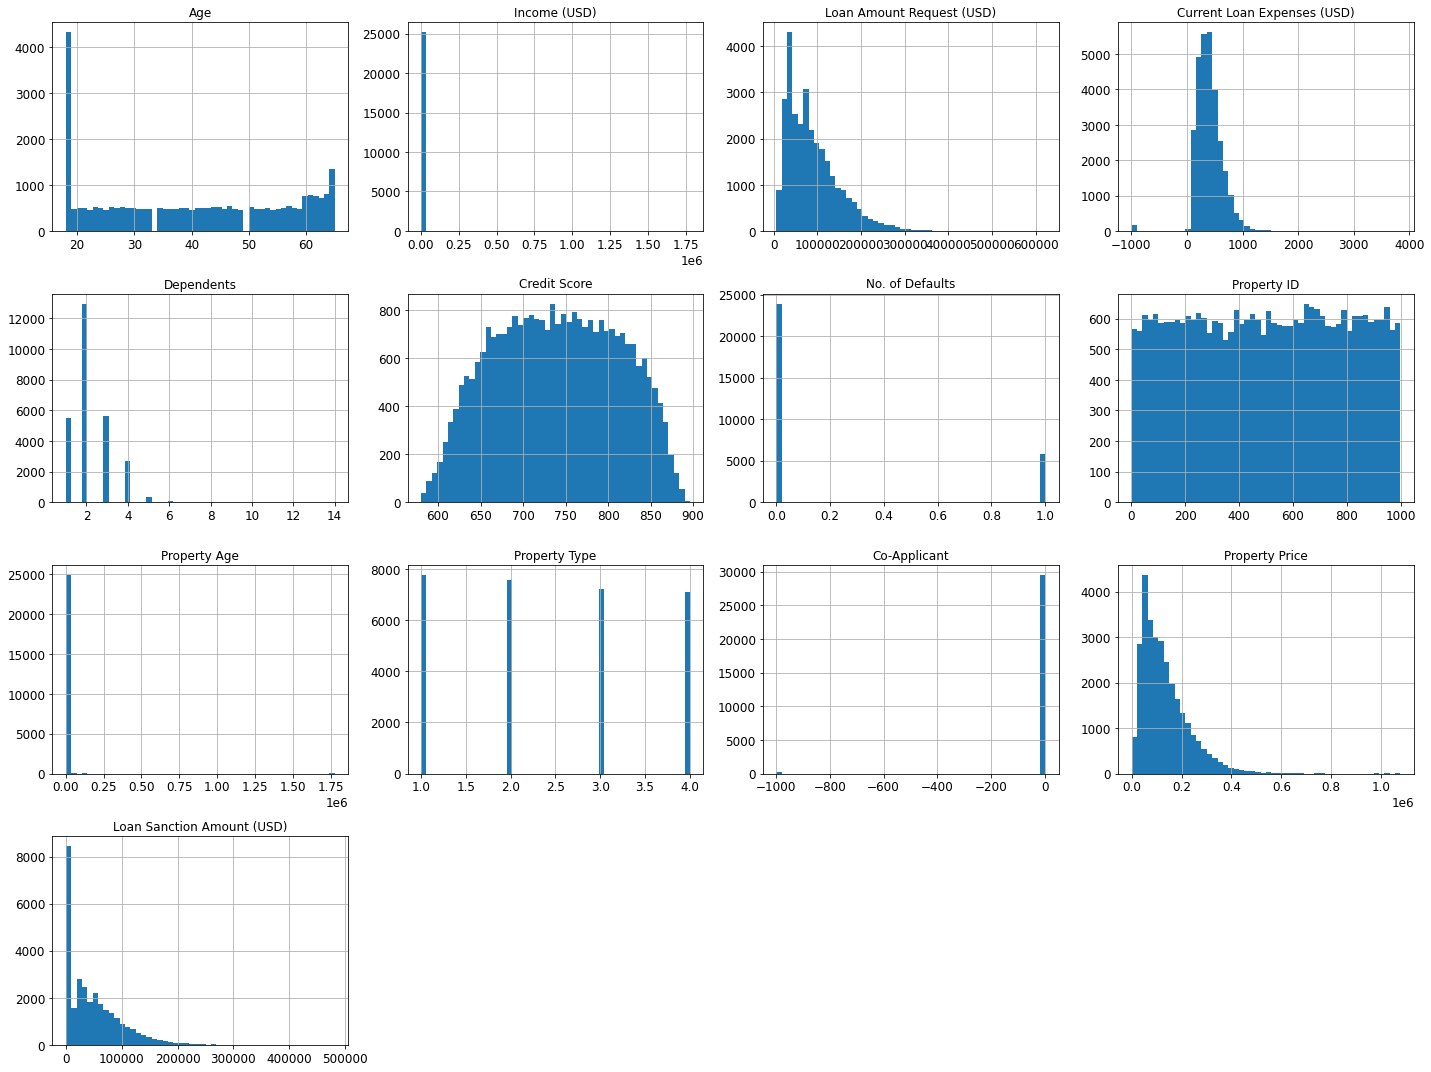

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
loan_df.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

## Create a Test Set

In [21]:
# to make this notebook's output identical at every run
np.random.seed(42)

In [22]:
import numpy as np

# For illustration only. Sklearn has train_test_split()
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [23]:
train_set, test_set = split_train_test(loan_df, 0.2)
len(train_set)

23728

In [24]:
len(test_set)

5932

In [25]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [26]:
loan_with_id = loan_df.reset_index()   # adds an `index` column
train_set, test_set = split_train_test_by_id(loan_with_id, 0.2, "index")

In [27]:
train_set, test_set = split_train_test_by_id(loan_with_id, 0.2, "index")

In [28]:
test_set.head()

,index,Customer ID,Name,Gender,Age,Income (USD),Income Stability,Profession,Type of Employment,Location,...,Credit Score,No. of Defaults,Has Active Credit Card,Property ID,Property Age,Property Type,Property Location,Co-Applicant,Property Price,Loan Sanction Amount (USD)
2,2,C-3770,Rosetta Verne,F,65,988.19,High,Pensioner,NaN,Semi-Urban,...,833.15,0,Unpossessed,546,988.19,2,Urban,0,72440.58,36474.43
5,5,C-17688,Polly Crumpler,F,60,1234.92,Low,State servant,Secretaries,Rural,...,684.12,1,Inactive,491,1234.92,2,Rural,1,43146.82,22382.57
12,12,C-30073,Brinda Vaz,F,48,777.25,Low,Working,NaN,Semi-Urban,...,764.11,0,Active,678,777.25,1,Semi-Urban,1,146073.26,67256.42
16,16,C-45549,Elidia Mccluney,F,61,2077.42,Low,Working,Realty agents,Semi-Urban,...,779.55,0,Inactive,395,2077.42,4,Rural,1,102502.20,0.00
23,23,C-35716,Blossom Lentine,F,24,2538.85,Low,Working,Laborers,Rural,...,721.27,1,Inactive,640,2538.85,1,Rural,1,170642.55,84367.95


In [29]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(loan_df, test_size=0.2, random_state=42)

In [30]:
test_set.head()

,Customer ID,Name,Gender,Age,Income (USD),Income Stability,Profession,Type of Employment,Location,Loan Amount Request (USD),...,Credit Score,No. of Defaults,Has Active Credit Card,Property ID,Property Age,Property Type,Property Location,Co-Applicant,Property Price,Loan Sanction Amount (USD)
25637,C-10160,Arlen Wanamaker,M,35,1848.98,Low,Working,Laborers,Semi-Urban,84001.94,...,NaN,0,Inactive,887,1848.98,1,Rural,1,97181.99,54601.26
23581,C-14801,Deanna Beauchesne,F,44,3168.31,Low,State servant,NaN,Semi-Urban,77944.47,...,730.57,0,Active,948,3168.31,3,Rural,1,121489.68,50663.91
26860,C-6046,Eliz Cheng,M,53,1419.42,Low,Working,Private service staff,Semi-Urban,14015.89,...,652.11,0,Active,576,1419.42,3,Rural,1,23475.22,9110.33
8643,C-46590,Hal Kuo,F,53,2492.76,Low,State servant,Drivers,Semi-Urban,122439.74,...,747.09,0,Active,792,2492.76,4,Rural,1,176859.09,0.00
28968,C-28785,Lucio Borel,F,48,2033.89,Low,Working,Laborers,Semi-Urban,55111.86,...,653.19,0,Inactive,768,2033.89,2,Semi-Urban,1,74233.81,38578.30


<AxesSubplot:>

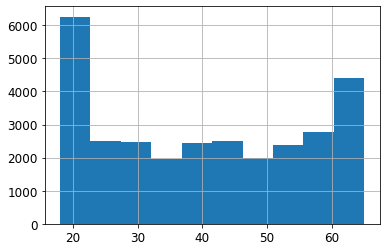

In [31]:
loan_df["Age"].hist()

In [32]:
loan_df["age_cat"] = pd.cut(loan_df["Age"],
                               bins=[0, 20, 30, 40, 50, 60, np.inf],
                               labels=[1, 2, 3, 4, 5, 6])

In [33]:
loan_df["age_cat"].value_counts()

1    5298
5    5185
4    4981
2    4954
3    4835
6    4407
Name: age_cat, dtype: int64

<AxesSubplot:>

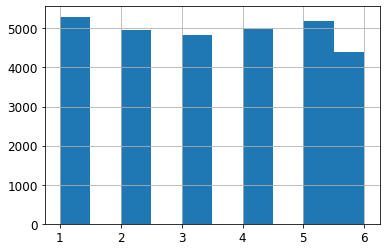

In [34]:
loan_df["age_cat"].hist()

In [35]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(loan_df, loan_df["age_cat"]):
    strat_train_set = loan_df.loc[train_index]
    strat_test_set = loan_df.loc[test_index]

In [36]:
strat_test_set["age_cat"].value_counts() / len(strat_test_set)

1    0.178692
5    0.174815
4    0.167903
2    0.167060
3    0.163014
6    0.148517
Name: age_cat, dtype: float64

In [37]:
loan_df["age_cat"].value_counts() / len(loan_df)

1    0.178624
5    0.174815
4    0.167937
2    0.167026
3    0.163014
6    0.148584
Name: age_cat, dtype: float64

In [38]:
def age_cat_proportions(data):
    return data["age_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(loan_df, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": age_cat_proportions(loan_df),
    "Stratified": age_cat_proportions(strat_test_set),
    "Random": age_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [39]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.178624,0.178692,0.181558,1.642129,3.775009e-02
2,0.167026,0.167060,0.168409,0.827614,2.018571e-02
3,0.163014,0.163014,0.165037,1.240951,-1.421085e-14
4,0.167937,0.167903,0.166049,-1.124272,-2.007629e-02
5,0.174815,0.174815,0.173803,-0.578592,0.000000e+00
6,0.148584,0.148517,0.145145,-2.314500,-4.538235e-02


In [40]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("age_cat", axis=1, inplace=True)

# Discover and Visualize the Data to Gain Insights

In [41]:
loan_df = strat_train_set.copy()

## Visualizing Geographical Data

Saving figure bad_visualization_plot


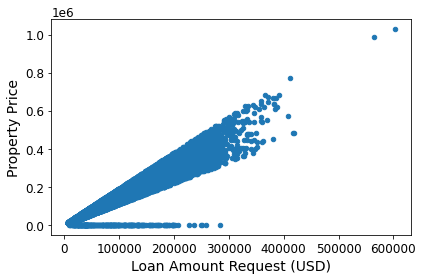

In [42]:
loan_df.plot(kind="scatter", x="Loan Amount Request (USD)", y="Property Price")
save_fig("bad_visualization_plot")

Saving figure better_visualization_plot


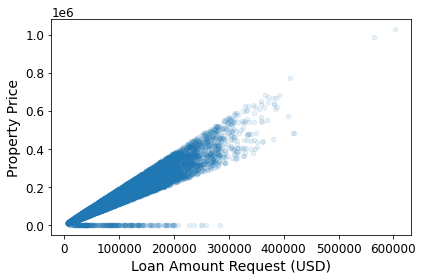

In [43]:
loan_df.plot(kind="scatter", x="Loan Amount Request (USD)", y="Property Price", alpha=0.1)
save_fig("better_visualization_plot")

The argument `sharex=False` fixes a display bug (the x-axis values and legend were not displayed)

Saving figure loan_sanction_amount_scatterplot


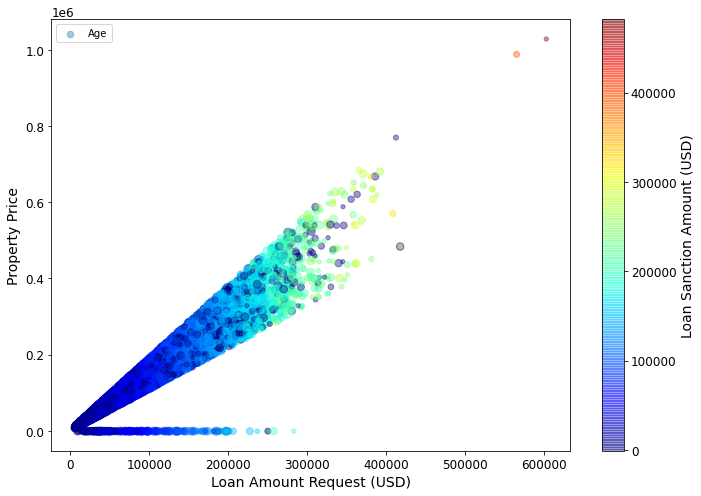

In [44]:
loan_df.plot(kind="scatter", x="Loan Amount Request (USD)", y="Property Price", alpha=0.4,
             s=loan_df["Age"], label="Age", figsize=(10,7),
             c="Loan Sanction Amount (USD)", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)
plt.legend()
save_fig("loan_sanction_amount_scatterplot")

## Looking for Correlations

In [45]:
corr_matrix = loan_df.corr()
corr_matrix["Loan Sanction Amount (USD)"].sort_values(ascending=False)

Loan Sanction Amount (USD)     1.000000
Loan Amount Request (USD)      0.726708
Property Price                 0.688896
Current Loan Expenses (USD)    0.486093
Credit Score                   0.368329
Income (USD)                   0.035110
Property Age                   0.034789
Age                            0.007685
Dependents                     0.006162
Property Type                  0.002239
No. of Defaults               -0.004063
Co-Applicant                  -0.006897
Property ID                   -0.011950
Name: Loan Sanction Amount (USD), dtype: float64

In [46]:
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.8
to_drop = [column for column in upper.columns if ((any(upper[column] >= 0.8)) | (any(upper[column] <= -0.8)))]

# Drop features 
loan_df.drop(to_drop, axis=1, inplace=True)
loan_df

<ipython-input-46-cc1b0cb4e0ac>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


,Customer ID,Name,Gender,Age,Income (USD),Income Stability,Profession,Type of Employment,Location,Loan Amount Request (USD),...,Expense Type 2,Dependents,Credit Score,No. of Defaults,Has Active Credit Card,Property ID,Property Type,Property Location,Co-Applicant,Loan Sanction Amount (USD)
6406,C-25781,Rosetta Ardoin,M,45,2067.47,Low,Working,Sales staff,Semi-Urban,82934.04,...,Y,2.0,764.80,0,Inactive,497,1,Semi-Urban,1,66347.23
13011,C-36977,Herma Gravelle,M,53,3664.28,Low,Working,Laborers,Urban,182017.80,...,N,4.0,742.68,0,Unpossessed,791,1,Rural,1,118311.57
24769,C-40824,Deborah Burger,F,28,4194.06,Low,Commercial associate,High skill tech staff,Semi-Urban,64737.67,...,Y,2.0,814.64,1,Inactive,46,2,Rural,1,48553.25
16131,C-44935,Leonel Vanduyn,M,35,5506.36,Low,Commercial associate,Sales staff,Semi-Urban,288712.23,...,N,2.0,765.05,1,Active,100,2,Semi-Urban,0,0.00
21923,C-24740,Meghann Mccumber,M,29,1611.71,Low,Working,Core staff,Semi-Urban,120105.22,...,N,3.0,795.81,0,Active,478,1,Rural,1,84073.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20410,C-8689,Angelyn Linen,F,18,1510.64,Low,Working,Laborers,Rural,26067.36,...,Y,1.0,NaN,1,Active,273,4,Rural,1,18247.15
10651,C-4938,Billye Shoaf,F,18,2762.50,Low,Working,NaN,Semi-Urban,32616.54,...,Y,NaN,738.27,0,Inactive,456,3,Rural,1,-999.00
23064,C-40830,Tandra Smiley,F,63,3435.20,Low,Working,Laborers,Semi-Urban,107706.39,...,Y,3.0,765.96,0,Unpossessed,132,1,Semi-Urban,1,75394.47
2493,C-5310,Gay Riles,F,26,1555.88,Low,Working,Sales staff,Semi-Urban,77354.46,...,Y,3.0,626.36,0,Unpossessed,619,4,Urban,1,0.00


Saving figure scatter_matrix_plot


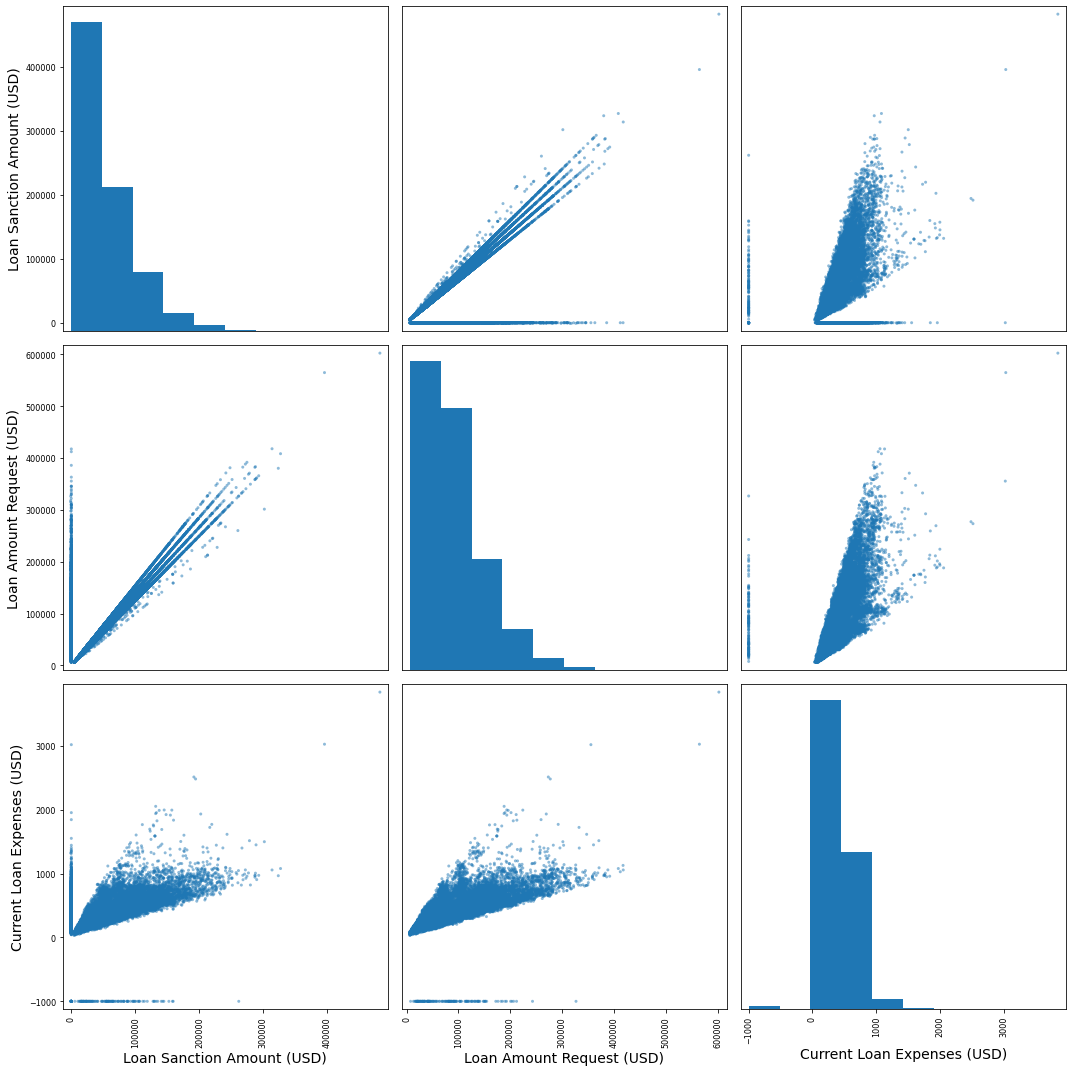

In [47]:
from pandas.plotting import scatter_matrix

attributes = ["Loan Sanction Amount (USD)","Loan Amount Request (USD)", 
              "Current Loan Expenses (USD)"]
scatter_matrix(loan_df[attributes], figsize=(15, 15))
save_fig("scatter_matrix_plot")

Saving figure loan_amount_vs_request_value_scatterplot


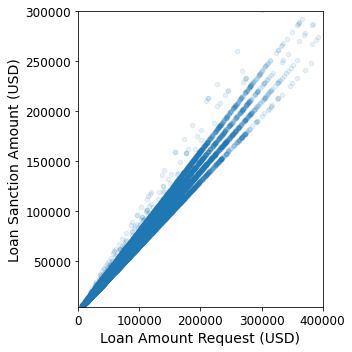

In [48]:
loan_df.plot(kind="scatter", x="Loan Amount Request (USD)", y="Loan Sanction Amount (USD)",
             alpha=0.1, figsize=(5, 5))
plt.axis([0, 400000, 4000, 300000])
save_fig("loan_amount_vs_request_value_scatterplot")

# 3. Data prepraration

In [49]:
loan_df = strat_train_set
loan_df.drop(to_drop, axis=1, inplace=True)

## Data Cleaning

In the book 3 options are listed:

```python
loan_df.dropna(subset=["Income (USD)"])    # option 1
loan_df.drop("Income (USD)", axis=1)       # option 2
median = loan_dg["Income (USD)"].median()  # option 3
loan_df["Income (USD)"].fillna(median, inplace=True)
```

To demonstrate each of them, let's create a copy of the dataset, but keeping only the rows that contain at least one null. Then it will be easier to visualize exactly what each option does:

In [50]:
sample_incomplete_rows = loan_df[loan_df.isnull().any(axis=1)]
sample_incomplete_rows

,Customer ID,Name,Gender,Age,Income (USD),Income Stability,Profession,Type of Employment,Location,Loan Amount Request (USD),...,Expense Type 2,Dependents,Credit Score,No. of Defaults,Has Active Credit Card,Property ID,Property Type,Property Location,Co-Applicant,Loan Sanction Amount (USD)
23657,C-17404,Leslie Kinsey,M,64,NaN,High,Pensioner,NaN,Urban,105998.97,...,Y,2.0,847.81,1,Inactive,774,3,Urban,1,79499.23
19468,C-16420,Caroyln Lawry,M,53,1583.23,Low,Working,NaN,Semi-Urban,116486.82,...,Y,2.0,859.43,0,Inactive,128,1,Rural,1,87365.12
21609,C-12519,Darlena Haddox,F,20,3490.06,Low,Commercial associate,NaN,Semi-Urban,60793.29,...,N,2.0,619.19,0,NaN,326,3,Urban,0,0.00
5123,C-23156,Merlyn Chadwell,F,56,NaN,Low,Working,Core staff,Semi-Urban,124171.75,...,N,3.0,709.70,0,Active,129,4,Semi-Urban,1,80711.64
9020,C-33243,Marlena Grajeda,F,52,2440.02,Low,Commercial associate,NaN,Semi-Urban,104883.68,...,Y,2.0,701.74,0,Unpossessed,931,2,Urban,1,73418.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16590,C-17141,Birgit Eddleman,F,18,NaN,Low,Working,Sales staff,Semi-Urban,78150.96,...,Y,1.0,637.14,1,Unpossessed,764,1,Urban,1,0.00
2320,C-32662,Sallie Vancleve,F,52,1332.02,Low,Working,NaN,Rural,18766.37,...,Y,3.0,736.93,0,NaN,146,2,Semi-Urban,1,13136.46
20354,C-36495,Lenita Oakman,M,40,2417.46,Low,Commercial associate,Sales staff,Urban,28142.05,...,Y,3.0,631.33,0,NaN,327,1,Rural,1,0.00
20410,C-8689,Angelyn Linen,F,18,1510.64,Low,Working,Laborers,Rural,26067.36,...,Y,1.0,NaN,1,Active,273,4,Rural,1,18247.15


In [51]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [52]:
loan_df.isnull().sum()

Customer ID                       0
Name                              0
Gender                           42
Age                               0
Income (USD)                   3579
Income Stability               1322
Profession                        0
Type of Employment             5734
Location                          0
Loan Amount Request (USD)         0
Current Loan Expenses (USD)     134
Expense Type 1                    0
Expense Type 2                    0
Dependents                     1936
Credit Score                   1332
No. of Defaults                   0
Has Active Credit Card         1266
Property ID                       0
Property Type                     0
Property Location               271
Co-Applicant                      0
Loan Sanction Amount (USD)        0
dtype: int64

Remove the text attribute because median can only be calculated on numerical attributes:

In [53]:
loan_df = loan_df.loc[loan_df["Co-Applicant"] >= 0 ]
co_applicant=loan_df["Co-Applicant"]
loan_df.drop("Co-Applicant", axis=1, inplace=True)
loan_df_labels = loan_df["Loan Sanction Amount (USD)"].copy()
loan_df.drop("Loan Sanction Amount (USD)", axis=1, inplace=True) # drop labels for training set
loan_df_num = loan_df.select_dtypes(include=[np.number])

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [54]:
imputer.fit(loan_df_num)

SimpleImputer(strategy='median')

In [55]:
imputer.statistics_

array([4.0000000e+01, 2.2166200e+03, 7.5110315e+04, 3.7444000e+02,
       2.0000000e+00, 7.3959500e+02, 0.0000000e+00, 5.0300000e+02,
       2.0000000e+00])

Check that this is the same as manually computing the median of each attribute:

In [56]:
loan_df_num.median().values

array([4.0000000e+01, 2.2166200e+03, 7.5110315e+04, 3.7444000e+02,
       2.0000000e+00, 7.3959500e+02, 0.0000000e+00, 5.0300000e+02,
       2.0000000e+00])

Transform the training set:

In [57]:
X = imputer.transform(loan_df_num)

In [58]:
loan_df_tr = pd.DataFrame(X, columns=loan_df_num.columns,
                          index=loan_df.index)

In [59]:
imputer.strategy

'median'

In [60]:
loan_df_tr = pd.DataFrame(X, columns=loan_df_num.columns,
                          index=loan_df_num.index)

In [61]:
loan_df_tr

,Age,Income (USD),Loan Amount Request (USD),Current Loan Expenses (USD),Dependents,Credit Score,No. of Defaults,Property ID,Property Type
6406,45.0,2067.47,82934.04,421.69,2.0,764.800,0.0,497.0,1.0
13011,53.0,3664.28,182017.80,701.13,4.0,742.680,0.0,791.0,1.0
24769,28.0,4194.06,64737.67,535.61,2.0,814.640,1.0,46.0,2.0
16131,35.0,5506.36,288712.23,747.66,2.0,765.050,1.0,100.0,2.0
21923,29.0,1611.71,120105.22,440.86,3.0,795.810,0.0,478.0,1.0
...,...,...,...,...,...,...,...,...,...
20410,18.0,1510.64,26067.36,134.80,1.0,739.595,1.0,273.0,4.0
10651,18.0,2762.50,32616.54,164.09,2.0,738.270,0.0,456.0,3.0
23064,63.0,3435.20,107706.39,508.47,3.0,765.960,0.0,132.0,1.0
2493,26.0,1555.88,77354.46,379.35,3.0,626.360,0.0,619.0,4.0


## Handling Text and Categorical Attributes

Now let's preprocess the categorical input features, excluding `Customer ID` and `Name` variables:

In [62]:
loan_df_cat = loan_df[["Gender","Income Stability","Profession","Type of Employment","Location","Expense Type 1",
                       "Expense Type 2", "Has Active Credit Card", "Property Location"]]
loan_df_cat.drop("Type of Employment", axis=1, inplace=True) 
loan_df_cat=loan_df_cat.dropna()  

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [63]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
loan_df_cat_encoded = ordinal_encoder.fit_transform(loan_df_cat)
loan_df_cat_encoded[:10]

array([[1., 1., 4., 1., 0., 1., 1., 1.],
       [1., 1., 4., 2., 1., 0., 2., 0.],
       [0., 1., 0., 1., 0., 1., 1., 0.],
       [1., 1., 0., 1., 0., 0., 0., 1.],
       [1., 1., 4., 1., 0., 0., 0., 0.],
       [1., 1., 4., 1., 0., 0., 2., 2.],
       [1., 0., 1., 2., 1., 1., 1., 2.],
       [1., 1., 4., 1., 1., 1., 1., 0.],
       [0., 1., 4., 1., 0., 0., 0., 1.],
       [0., 1., 0., 1., 0., 1., 2., 2.]])

In [64]:
ordinal_encoder.categories_

[array(['F', 'M'], dtype=object),
 array(['High', 'Low'], dtype=object),
 array(['Commercial associate', 'Pensioner', 'State servant', 'Unemployed',
        'Working'], dtype=object),
 array(['Rural', 'Semi-Urban', 'Urban'], dtype=object),
 array(['N', 'Y'], dtype=object),
 array(['N', 'Y'], dtype=object),
 array(['Active', 'Inactive', 'Unpossessed'], dtype=object),
 array(['Rural', 'Semi-Urban', 'Urban'], dtype=object)]

In [65]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
loan_df_cat_1hot = cat_encoder.fit_transform(loan_df_cat)
loan_df_cat_1hot

<20820x22 sparse matrix of type '<class 'numpy.float64'>'
	with 166560 stored elements in Compressed Sparse Row format>

By default, the `OneHotEncoder` class returns a sparse array, but we can convert it to a dense array if needed by calling the `toarray()` method:

In [66]:
loan_df_cat_1hot.toarray()

array([[0., 1., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.]])

Alternatively, you can set `sparse=False` when creating the `OneHotEncoder`:

In [67]:
cat_encoder = OneHotEncoder(sparse=False)
loan_df_cat_1hot = cat_encoder.fit_transform(loan_df_cat)
loan_df_cat_1hot

array([[0., 1., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.]])

In [68]:
cat_encoder.categories_

[array(['F', 'M'], dtype=object),
 array(['High', 'Low'], dtype=object),
 array(['Commercial associate', 'Pensioner', 'State servant', 'Unemployed',
        'Working'], dtype=object),
 array(['Rural', 'Semi-Urban', 'Urban'], dtype=object),
 array(['N', 'Y'], dtype=object),
 array(['N', 'Y'], dtype=object),
 array(['Active', 'Inactive', 'Unpossessed'], dtype=object),
 array(['Rural', 'Semi-Urban', 'Urban'], dtype=object)]

## Transformation Pipelines

Now let's build a pipeline for preprocessing the numerical attributes:

In [69]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

loan_df_num_tr = num_pipeline.fit_transform(loan_df_num)

In [70]:
loan_df_num_tr

array([[ 0.30548212, -0.04393276, -0.09911689, ..., -0.49298327,
        -0.01447273, -1.30428947],
       [ 0.80399818,  0.09296566,  1.5675719 , ..., -0.49298327,
         1.00661212, -1.30428947],
       [-0.7538645 ,  0.138385  , -0.40519818, ...,  2.0284664 ,
        -1.58083078, -0.40830724],
       ...,
       [ 1.42714326,  0.07332607,  0.31757903, ..., -0.49298327,
        -1.2821461 , -1.30428947],
       [-0.87849352, -0.08779262, -0.19297105, ..., -0.49298327,
         0.40924275,  1.38365723],
       [-0.81617901, -0.10682865, -0.16507828, ..., -0.49298327,
         0.08277345, -1.30428947]])

In [71]:
from sklearn.compose import ColumnTransformer

num_attribs = list(loan_df_num)
cat_attribs = ["Gender","Income Stability","Profession","Type of Employment","Location","Expense Type 1",
                       "Expense Type 2", "Has Active Credit Card", "Property Location"]

enc = OneHotEncoder()
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", enc, cat_attribs),
    ])

loan_df_prepared = full_pipeline.fit_transform(loan_df)
enc.fit(loan_df[cat_attribs])
cat_attribs_c = list(enc.get_feature_names(cat_attribs))
feature_names = num_attribs + cat_attribs_c
len(feature_names)

57

In [72]:
loan_df_prepared.shape

(23594, 57)

In [138]:
feature_names

['Age',
 'Income (USD)',
 'Loan Amount Request (USD)',
 'Current Loan Expenses (USD)',
 'Dependents',
 'Credit Score',
 'No. of Defaults',
 'Property ID',
 'Property Type',
 'Gender_F',
 'Gender_M',
 'Gender_nan',
 'Income Stability_High',
 'Income Stability_Low',
 'Income Stability_nan',
 'Profession_Businessman',
 'Profession_Commercial associate',
 'Profession_Maternity leave',
 'Profession_Pensioner',
 'Profession_State servant',
 'Profession_Student',
 'Profession_Unemployed',
 'Profession_Working',
 'Type of Employment_Accountants',
 'Type of Employment_Cleaning staff',
 'Type of Employment_Cooking staff',
 'Type of Employment_Core staff',
 'Type of Employment_Drivers',
 'Type of Employment_HR staff',
 'Type of Employment_High skill tech staff',
 'Type of Employment_IT staff',
 'Type of Employment_Laborers',
 'Type of Employment_Low-skill Laborers',
 'Type of Employment_Managers',
 'Type of Employment_Medicine staff',
 'Type of Employment_Private service staff',
 'Type of Employm

# 4. Causal Inference

In [147]:
from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor

from causalml.inference.meta import BaseSRegressor, BaseTRegressor, BaseXRegressor, BaseRRegressor
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.dataset.regression import synthetic_data
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

import shap

import time
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'  # for lightgbm to work

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [74]:
w = co_applicant.to_numpy()
w.shape

(23594,)

In [75]:
w_multi = np.array(['treatment_A' if x==1 else 'control' for x in w])

## LRS Regressor

In [168]:
model_tau = LinearRegression()  # specify model for model_tau
LRS = LRSRegressor(control_name='control')
te, lb, ub = LRS.estimate_ate(loan_df_prepared, w_multi, loan_df_labels)
print('Average Treatment Effect (Linear Regression): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

Average Treatment Effect (Linear Regression): 34173.74 (32817.15, 35530.32)


In [125]:
LRS_tau = LRS.fit_predict(loan_df_prepared, w_multi, loan_df_labels)
LRS_tau.shape

(23594, 1)

## Feature Importance (method = auto)

In [126]:
LRS.get_importance(X=loan_df_prepared, 
                        tau=LRS_tau,
                        normalize=True, 
                        method='auto', 
                        features=feature_names)

{'treatment_A': Age                                         0.844626
 Income (USD)                                0.085442
 Loan Amount Request (USD)                   0.035102
 Credit Score                                0.034830
 Location_Semi-Urban                         0.000000
 Type of Employment_Low-skill Laborers       0.000000
 Type of Employment_Managers                 0.000000
 Type of Employment_Medicine staff           0.000000
 Type of Employment_Private service staff    0.000000
 Type of Employment_Realty agents            0.000000
 Type of Employment_Sales staff              0.000000
 Type of Employment_Secretaries              0.000000
 Type of Employment_Security staff           0.000000
 Type of Employment_Waiters/barmen staff     0.000000
 Type of Employment_nan                      0.000000
 Location_Rural                              0.000000
 Location_Urban                              0.000000
 Type of Employment_IT staff                 0.000000
 Expense Type

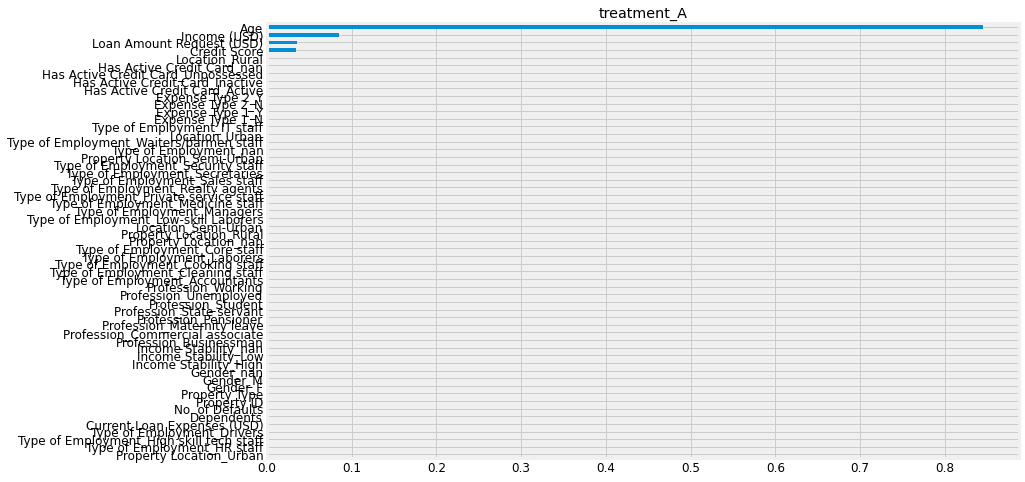

In [127]:
LRS.plot_importance(X=loan_df_prepared, 
                        tau=LRS_tau,
                        normalize=True, 
                        method='auto', 
                        features=feature_names)

## Feature Importance (method = permutation)

In [128]:
LRS.get_importance(X=loan_df_prepared, 
                        tau=LRS_tau, 
                        method='permutation', 
                        features=feature_names,
                        random_state=42)

{'treatment_A': Age                                         0.0
 Type of Employment_High skill tech staff    0.0
 Type of Employment_Laborers                 0.0
 Type of Employment_Low-skill Laborers       0.0
 Type of Employment_Managers                 0.0
 Type of Employment_Medicine staff           0.0
 Type of Employment_Private service staff    0.0
 Type of Employment_Realty agents            0.0
 Type of Employment_Sales staff              0.0
 Type of Employment_Secretaries              0.0
 Type of Employment_Security staff           0.0
 Type of Employment_Waiters/barmen staff     0.0
 Type of Employment_nan                      0.0
 Location_Rural                              0.0
 Location_Semi-Urban                         0.0
 Location_Urban                              0.0
 Expense Type 1_N                            0.0
 Expense Type 1_Y                            0.0
 Expense Type 2_N                            0.0
 Expense Type 2_Y                            0.0
 Has 

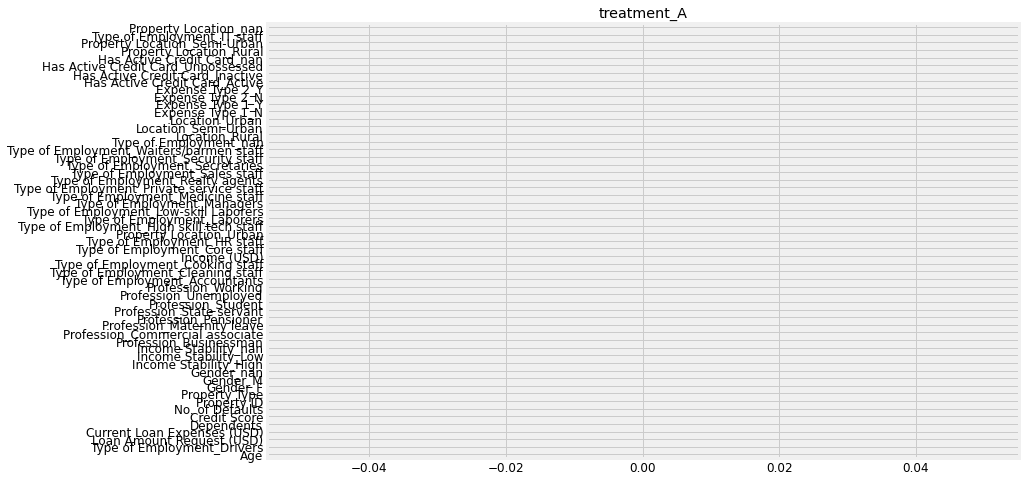

In [129]:
LRS.plot_importance(X=loan_df_prepared, 
                        tau=LRS_tau, 
                        method='permutation', 
                        features=feature_names,
                        random_state=42)

## Feature Importance (sklearn.inspection.permutation_importance)

In [130]:
start_time = time.time()
X_train, X_test, y_train, y_test = train_test_split(loan_df_prepared, LRS_tau, test_size=0.3, random_state=42)
model_tau_fit = model_tau.fit(X_train, y_train)

perm_imp_test = permutation_importance(
    estimator=model_tau_fit, 
    X=X_test, 
    y=y_test, 
    random_state=42).importances_mean
pd.Series(perm_imp_test,feature_names).sort_values(ascending=False)

print("Elapsed time: %s seconds" % (time.time() - start_time))

Elapsed time: 1.3302397727966309 seconds


In [131]:
pd.Series(perm_imp_test,feature_names).sort_values(ascending=False)

Property Location_Semi-Urban                1.258375e+27
Property Location_Rural                     1.244035e+27
Property Location_Urban                     1.190502e+27
Income Stability_Low                        1.586748e+26
Income Stability_High                       1.023231e+26
Income Stability_nan                        6.820739e+25
Property Location_nan                       6.475492e+25
Expense Type 1_Y                            5.566709e+25
Expense Type 1_N                            5.564590e+25
Profession_Working                          2.759828e+25
Profession_Commercial associate             2.167597e+25
Location_Semi-Urban                         1.245684e+25
Profession_Pensioner                        9.294457e+24
Location_Rural                              8.920017e+24
Profession_State servant                    8.643877e+24
Type of Employment_nan                      8.478684e+24
Type of Employment_Laborers                 7.099625e+24
Location_Urban                 

Text(0.5, 1.0, 'Test Set Permutation Importances')

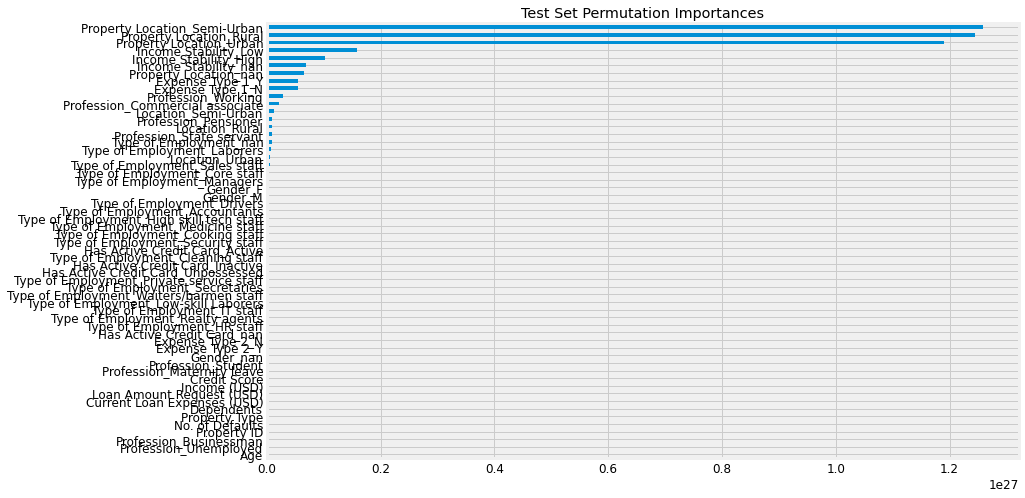

In [132]:
pd.Series(perm_imp_test, feature_names).sort_values().plot(kind='barh', figsize=(12, 8))
plt.title('Test Set Permutation Importances')

In [133]:
perm_imp_train = permutation_importance(
    estimator=model_tau_fit, 
    X=X_train, 
    y=y_train, 
    random_state=42).importances_mean
pd.Series(perm_imp_train,feature_names).sort_values(ascending=False)

Property Location_Semi-Urban                1.238683e+27
Property Location_Rural                     1.213342e+27
Property Location_Urban                     1.166232e+27
Income Stability_Low                        1.598668e+26
Income Stability_High                       1.034079e+26
Income Stability_nan                        6.864950e+25
Property Location_nan                       6.034288e+25
Expense Type 1_Y                            5.546969e+25
Expense Type 1_N                            5.546969e+25
Profession_Working                          2.683586e+25
Profession_Commercial associate             2.150360e+25
Location_Semi-Urban                         1.227842e+25
Profession_Pensioner                        9.254479e+24
Location_Rural                              8.885149e+24
Type of Employment_nan                      8.474018e+24
Profession_State servant                    7.980389e+24
Type of Employment_Laborers                 6.964878e+24
Location_Urban                 

Text(0.5, 1.0, 'Training Set Permutation Importances')

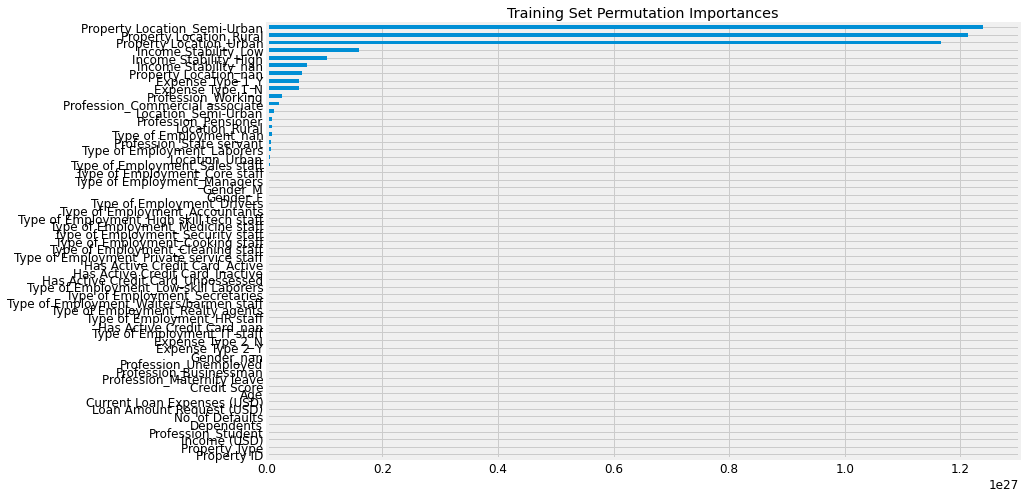

In [134]:
pd.Series(perm_imp_train,feature_names).sort_values().plot(kind='barh', figsize=(12, 8))
plt.title('Training Set Permutation Importances')

## Shapley Values

In [139]:
shap_LRS = LRS.get_shap_values(X=loan_df_prepared, tau=LRS_tau)
shap_LRS

{'treatment_A': array([[ 2.55795385e-13, -1.26565425e-14,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 1.13686838e-13, -1.26565425e-14,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 2.84217094e-14,  2.44249065e-15,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [ 5.11590770e-13, -6.50590692e-14,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 2.84217094e-14, -3.04201109e-14,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 2.84217094e-14, -3.04201109e-14,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])}

In [140]:
np.mean(np.abs(shap_LRS['treatment_A']),axis=0)

array([3.43791378e-13, 2.29307310e-14, 3.63794026e-16, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

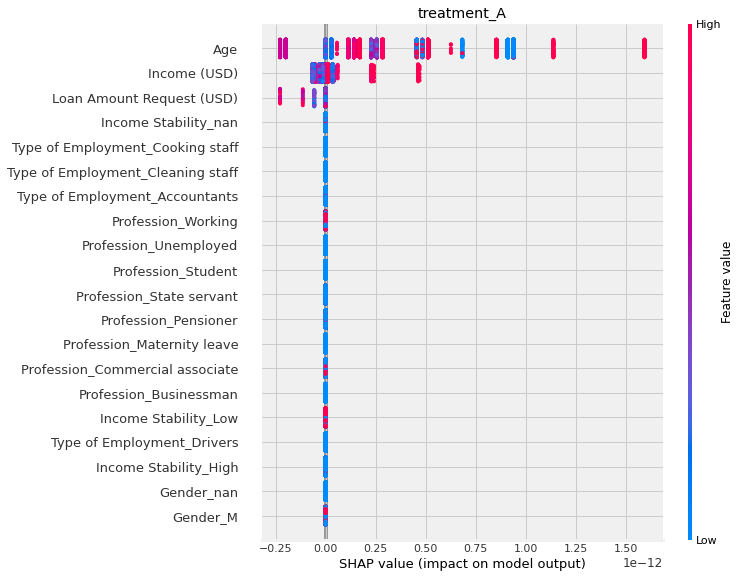

In [141]:
# Plot shap values without specifying shap_dict
LRS.plot_shap_values(X=loan_df_prepared, tau=LRS_tau, features=feature_names)

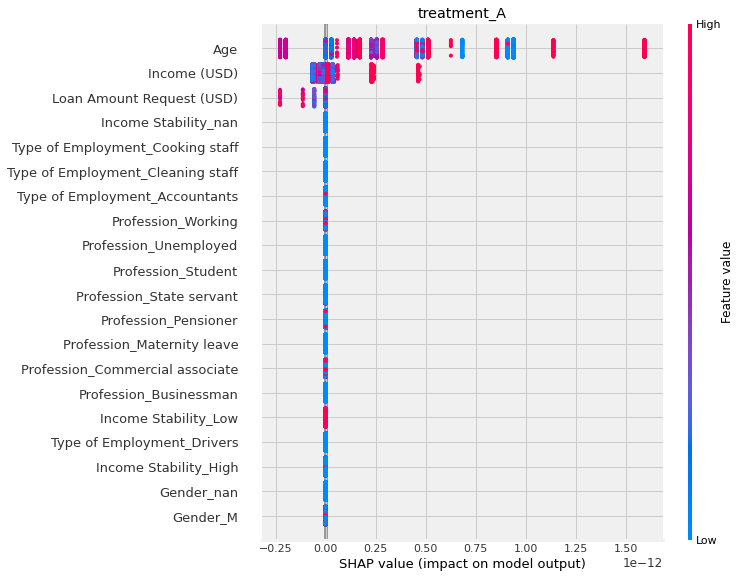

In [142]:
# Plot shap values WITH specifying shap_dict
LRS.plot_shap_values(X=loan_df_prepared, shap_dict=shap_LRS,features=feature_names)

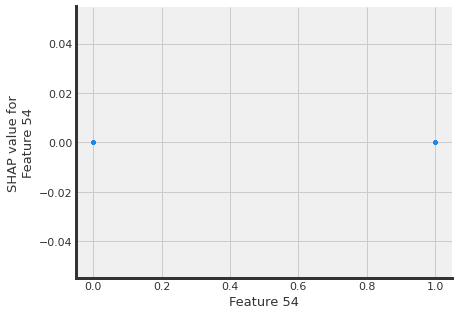

In [143]:
# interaction_idx set to None (no color coding for interaction effects)
LRS.plot_shap_dependence(treatment_group='treatment_A',
                              feature_idx=54,
                              X=loan_df_prepared,
                              tau=LRS_tau,
                              interaction_idx=None,
                              shap_dict=shap_LRS)

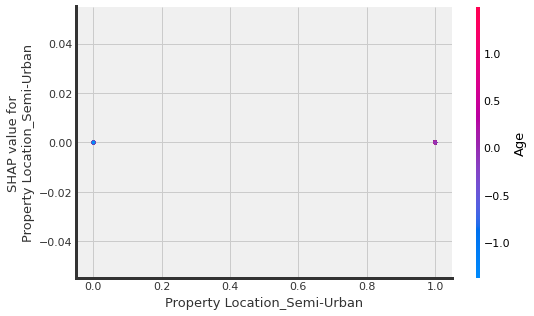

In [144]:
# interaction_idx set to 'auto' (searches for feature with greatest approximate interaction)
# specify feature names
LRS.plot_shap_dependence(treatment_group='treatment_A',
                              feature_idx='Property Location_Semi-Urban',
                              X=loan_df_prepared,
                              tau=LRS_tau,
                              interaction_idx='auto',
                              shap_dict=shap_LRS,
                              features=feature_names)

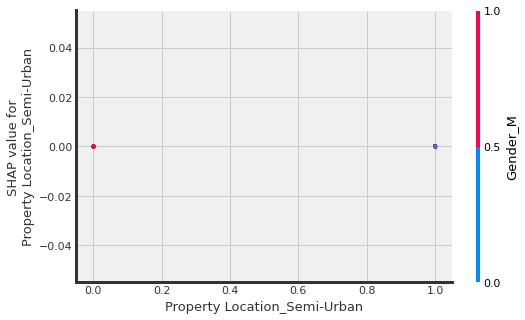

In [145]:
##### interaction_idx set to specific index
LRS.plot_shap_dependence(treatment_group='treatment_A',
                              feature_idx=54,
                              X=loan_df_prepared,
                              tau=LRS_tau,
                              interaction_idx=10,
                              shap_dict=shap_LRS, 
                              features=feature_names)

# XGBT Regressor

In [169]:
model_tau = XGBRegressor()  # specify model for model_tau
XGBT = XGBTRegressor(control_name='control')
te, lb, ub = XGBT.estimate_ate(loan_df_prepared, w_multi, loan_df_labels)
print('Average Treatment Effect (XGBoost): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

Average Treatment Effect (XGBoost): 42864.71 (42265.70, 43463.72)


In [149]:
XGBT_tau = XGBT.fit_predict(loan_df_prepared, w_multi, loan_df_labels)
XGBT_tau.shape

(23594, 1)

## Feature Importance (method = auto)

In [150]:
XGBT.get_importance(X=loan_df_prepared, 
                        tau=XGBT_tau,
                        normalize=True, 
                        method='auto', 
                        features=feature_names)

{'treatment_A': Loan Amount Request (USD)                   0.534283
 Credit Score                                0.306998
 Profession_Pensioner                        0.106282
 No. of Defaults                             0.015367
 Income (USD)                                0.008861
 Property ID                                 0.007397
 Current Loan Expenses (USD)                 0.005627
 Age                                         0.004037
 Profession_Commercial associate             0.000960
 Property Type                               0.000942
 Type of Employment_Managers                 0.000864
 Has Active Credit Card_Inactive             0.000820
 Profession_Working                          0.000731
 Expense Type 2_N                            0.000691
 Property Location_Urban                     0.000668
 Has Active Credit Card_nan                  0.000646
 Dependents                                  0.000621
 Gender_F                                    0.000516
 Expense Type

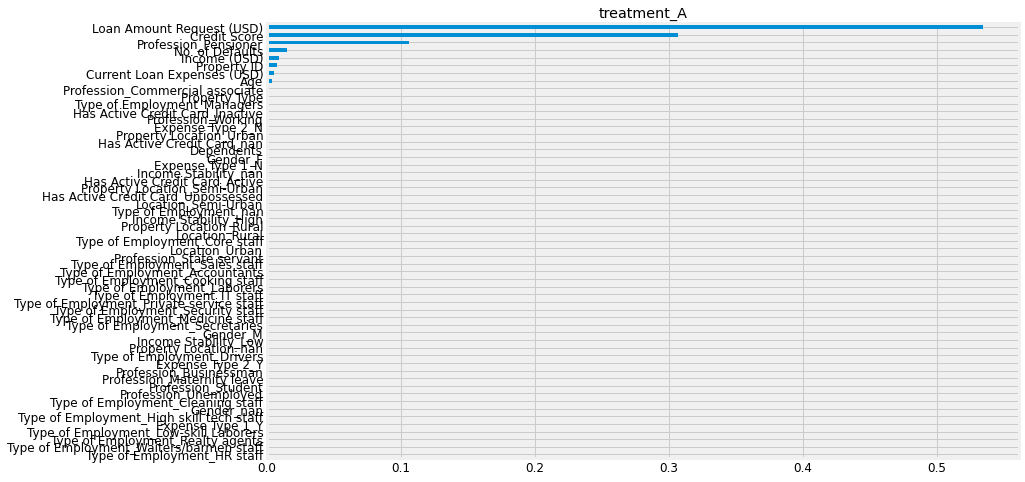

In [151]:
XGBT.plot_importance(X=loan_df_prepared, 
                        tau=XGBT_tau,
                        normalize=True, 
                        method='auto', 
                        features=feature_names)

## Feature Importance (method = permutation)

In [152]:
XGBT.get_importance(X=loan_df_prepared, 
                        tau=XGBT_tau, 
                        method='permutation', 
                        features=feature_names,
                        random_state=42)

{'treatment_A': Loan Amount Request (USD)                   1.178240
 Credit Score                                0.623307
 Profession_Pensioner                        0.244076
 No. of Defaults                             0.029988
 Income (USD)                                0.004816
 Type of Employment_Managers                 0.001485
 Current Loan Expenses (USD)                 0.000677
 Has Active Credit Card_Inactive             0.000559
 Property Location_Semi-Urban                0.000555
 Property ID                                 0.000542
 Income Stability_nan                        0.000446
 Has Active Credit Card_Active               0.000430
 Has Active Credit Card_nan                  0.000317
 Type of Employment_Sales staff              0.000282
 Type of Employment_Cooking staff            0.000151
 Location_Rural                              0.000140
 Property Type                               0.000101
 Income Stability_High                       0.000083
 Type of Empl

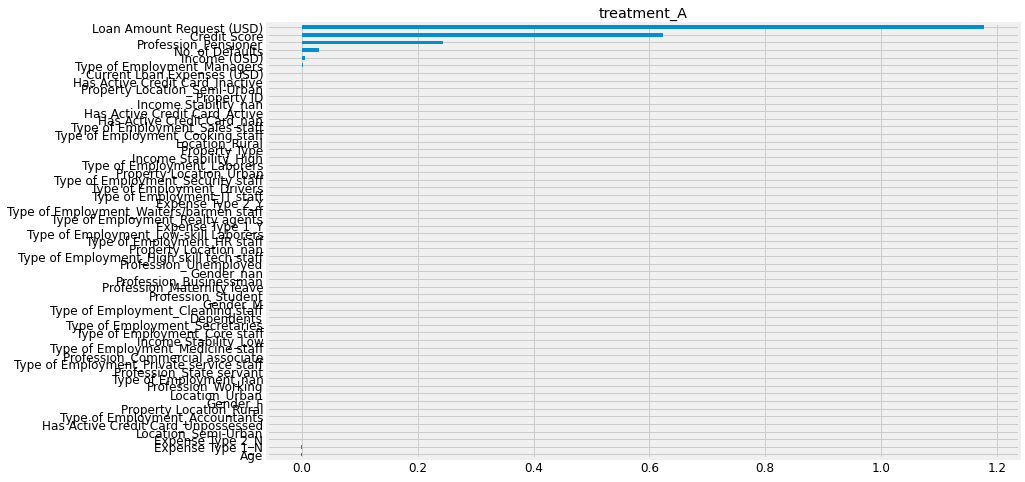

In [153]:
XGBT.plot_importance(X=loan_df_prepared, 
                        tau=XGBT_tau, 
                        method='permutation', 
                        features=feature_names,
                        random_state=42)

## Feature Importance (sklearn.inspection.permutation_importance)

In [154]:
start_time = time.time()
X_train, X_test, y_train, y_test = train_test_split(loan_df_prepared, XGBT_tau, test_size=0.3, random_state=42)
model_tau_fit = model_tau.fit(X_train, y_train)

perm_imp_test = permutation_importance(
    estimator=model_tau_fit, 
    X=X_test, 
    y=y_test, 
    random_state=42).importances_mean
pd.Series(perm_imp_test,feature_names).sort_values(ascending=False)

print("Elapsed time: %s seconds" % (time.time() - start_time))

Elapsed time: 20.82941484451294 seconds


In [155]:
pd.Series(perm_imp_test,feature_names).sort_values(ascending=False)

Loan Amount Request (USD)                   1.215893e+00
Credit Score                                6.321565e-01
Profession_Pensioner                        2.194920e-01
No. of Defaults                             2.900307e-02
Income (USD)                                1.367582e-02
Property ID                                 5.943728e-03
Current Loan Expenses (USD)                 5.846577e-03
Has Active Credit Card_Inactive             1.992498e-03
Profession_Working                          1.600799e-03
Type of Employment_Waiters/barmen staff     9.628649e-04
Property Location_Rural                     8.483688e-04
Income Stability_nan                        7.917299e-04
Dependents                                  7.681725e-04
Income Stability_High                       7.265375e-04
Type of Employment_Sales staff              6.877708e-04
Has Active Credit Card_nan                  4.536146e-04
Type of Employment_Laborers                 4.286721e-04
Profession_Commercial associate

Text(0.5, 1.0, 'Test Set Permutation Importances')

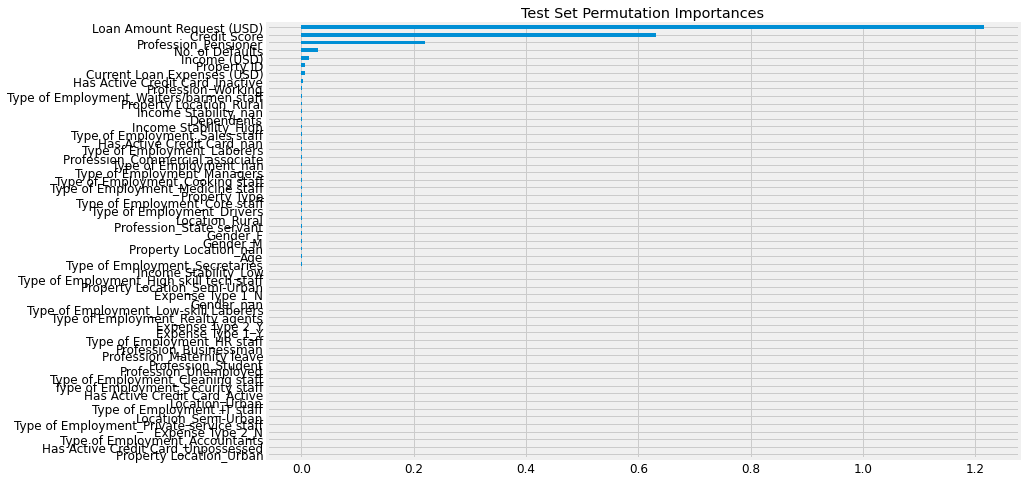

In [156]:
pd.Series(perm_imp_test, feature_names).sort_values().plot(kind='barh', figsize=(12, 8))
plt.title('Test Set Permutation Importances')

In [157]:
perm_imp_train = permutation_importance(
    estimator=model_tau_fit, 
    X=X_train, 
    y=y_train, 
    random_state=42).importances_mean
pd.Series(perm_imp_train,feature_names).sort_values(ascending=False)

Loan Amount Request (USD)                   1.229243
Credit Score                                0.708998
Profession_Pensioner                        0.241979
Income (USD)                                0.035596
No. of Defaults                             0.026064
Current Loan Expenses (USD)                 0.023612
Age                                         0.018558
Property ID                                 0.016639
Has Active Credit Card_Inactive             0.003685
Property Type                               0.002898
Dependents                                  0.002771
Profession_Working                          0.002239
Income Stability_High                       0.002208
Expense Type 2_N                            0.001969
Income Stability_nan                        0.001522
Has Active Credit Card_Unpossessed          0.001215
Property Location_Rural                     0.001208
Profession_Commercial associate             0.001106
Type of Employment_Laborers                 0.

Text(0.5, 1.0, 'Training Set Permutation Importances')

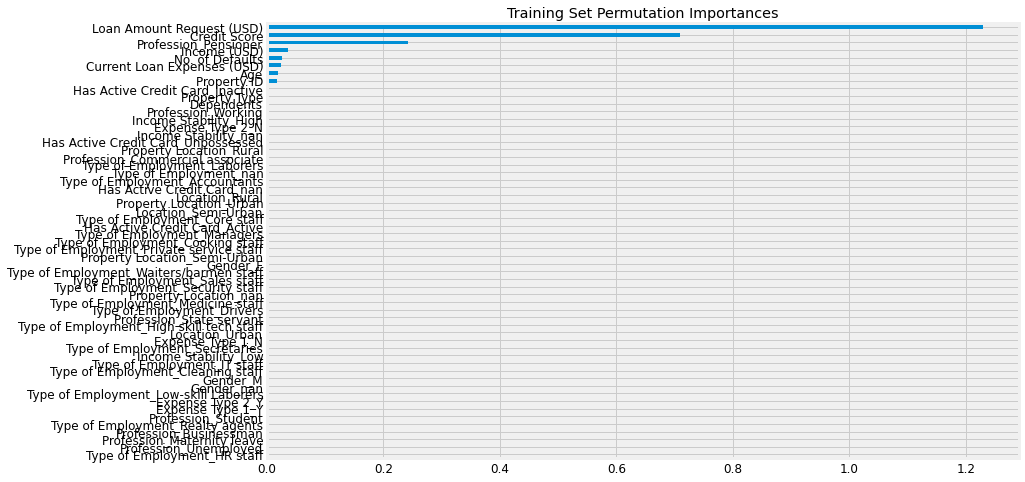

In [158]:
pd.Series(perm_imp_train,feature_names).sort_values().plot(kind='barh', figsize=(12, 8))
plt.title('Training Set Permutation Importances')

## Shapley Values

In [159]:
shap_XGBT = XGBT.get_shap_values(X=loan_df_prepared, tau=XGBT_tau)
shap_XGBT

{'treatment_A': array([[ 2.04325831e+02, -6.10729186e+02, -3.41486705e+03, ...,
         -7.89156560e+01,  2.49076997e+01, -7.57058752e-01],
        [ 1.10890705e+03, -1.06529989e+03,  5.24718290e+04, ...,
          7.46524010e+00,  9.48668567e+01, -6.90475228e-01],
        [ 3.17925754e+02, -8.24890458e+02, -1.22882451e+04, ...,
          3.13244799e+01,  3.41537478e+01, -7.34008097e-01],
        ...,
        [-1.19037347e+03, -1.31186011e+03,  8.03278285e+03, ...,
         -2.51145479e+00,  9.05368087e+01, -7.94787666e-01],
        [ 8.44040041e+01, -5.06148458e+02, -3.15542995e+03, ...,
          4.15968857e+01, -4.30445966e+01, -7.55727838e-01],
        [ 6.69653589e+01, -7.44918065e+02, -5.59777420e+03, ...,
          4.04160646e+01,  2.67569852e+01, -7.55189787e-01]])}

In [160]:
np.mean(np.abs(shap_XGBT['treatment_A']),axis=0)

array([3.11553474e+02, 1.25079202e+03, 2.26298995e+04, 4.28690471e+02,
       2.42005937e+02, 1.48012215e+04, 9.11687752e+02, 3.70373340e+02,
       7.06440311e+01, 4.17800429e+01, 7.59218209e+00, 0.00000000e+00,
       6.34159294e+01, 8.75515836e+00, 2.62980981e+02, 0.00000000e+00,
       1.66076017e+02, 0.00000000e+00, 5.98803427e+03, 2.50475918e+01,
       0.00000000e+00, 0.00000000e+00, 4.26697032e+01, 1.15777462e+01,
       0.00000000e+00, 5.29068201e+01, 1.48748189e+01, 5.67748981e+00,
       0.00000000e+00, 0.00000000e+00, 1.00472177e+01, 1.23472550e+02,
       0.00000000e+00, 1.95239971e+02, 8.13857904e+00, 5.37162372e+00,
       0.00000000e+00, 4.87621373e+00, 1.04711266e+01, 8.87312889e+00,
       0.00000000e+00, 2.94544407e+01, 2.70777502e+01, 9.93150488e+01,
       2.73647064e+01, 5.19458133e+01, 0.00000000e+00, 5.99645129e+01,
       0.00000000e+00, 4.90946967e+01, 1.24549864e+02, 1.90092864e+01,
       9.37743429e+01, 1.36421939e+01, 7.04931053e+01, 8.45868999e+01,
      

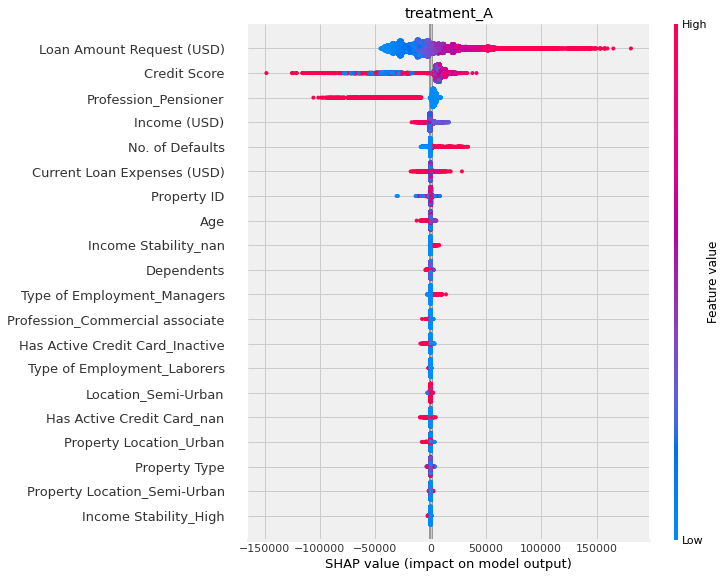

In [161]:
# Plot shap values without specifying shap_dict
XGBT.plot_shap_values(X=loan_df_prepared, tau=XGBT_tau, features=feature_names)

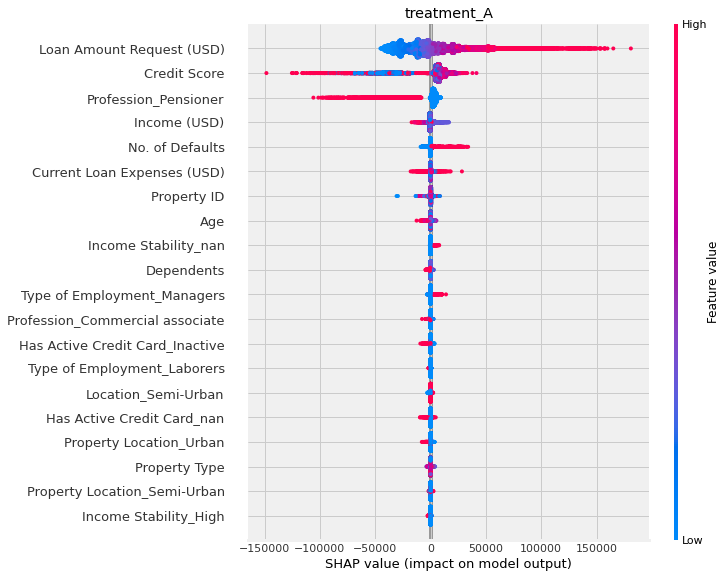

In [162]:
# Plot shap values WITH specifying shap_dict
XGBT.plot_shap_values(X=loan_df_prepared, shap_dict=shap_XGBT,features=feature_names)

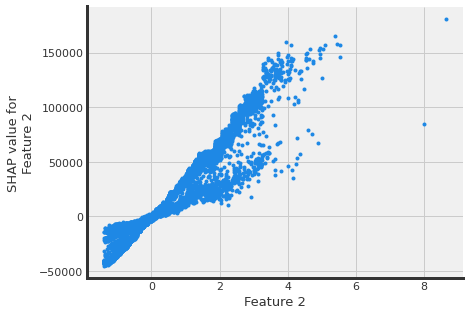

In [164]:
# interaction_idx set to None (no color coding for interaction effects)
XGBT.plot_shap_dependence(treatment_group='treatment_A',
                              feature_idx=2,
                              X=loan_df_prepared,
                              tau=XGBT_tau,
                              interaction_idx=None,
                              shap_dict=shap_XGBT)

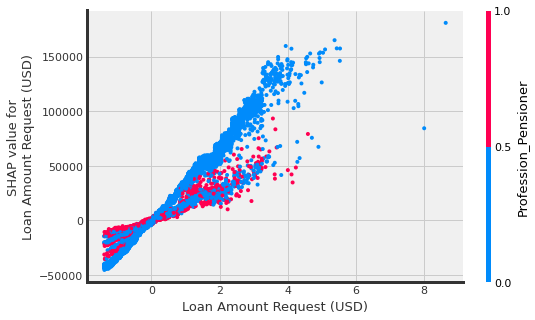

In [165]:
# interaction_idx set to 'auto' (searches for feature with greatest approximate interaction)
# specify feature names
XGBT.plot_shap_dependence(treatment_group='treatment_A',
                              feature_idx='Loan Amount Request (USD)',
                              X=loan_df_prepared,
                              tau=XGBT_tau,
                              interaction_idx='auto',
                              shap_dict=shap_XGBT,
                              features=feature_names)

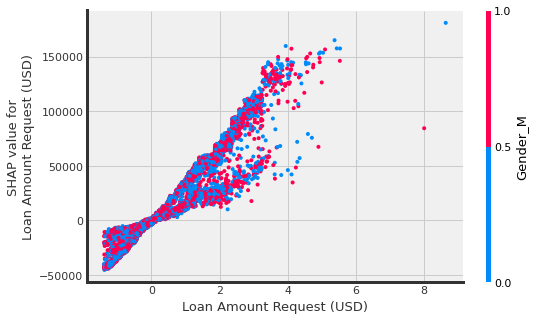

In [166]:
## interaction_idx set to specific index
XGBT.plot_shap_dependence(treatment_group='treatment_A',
                              feature_idx=2,
                              X=loan_df_prepared,
                              tau=XGBT_tau,
                              interaction_idx=10,
                              shap_dict=shap_XGBT, 
                              features=feature_names)

# 5. Conclusion

1. Linear regression does not provide meaningful result (feature importances are zero), as the correlation between loan issued and features provided in the treatment set is not linear (linear regression is too simple for this task)

2. Based on XGB model, causal impact of having co-applicant on amount of loan issued considering all other features are kept in their normal state is 1,198 (difference between average loan issued for the states that there is a co-applicant and when there is not). It means that customers with co-applicant would generally get ~$1200 more loan

3. Our hypothesis at the begining of this study that having co-applicant will result in more issued loan is confirmed based on thiis analysis


3. Loan Amount Request (USD), Credit Score, and Profession_Pensioner (if the applicant is a pensioner) are the most important variables in predicting the issued loan in the treatment set. Also, Profession_Pensioner has a lot of interaction with Loan_Amount_Request. Its causal effect on issued can be studied as the next step for this research. 